<a href="https://colab.research.google.com/github/LuciaManzanoUOC/MTP-UOC/blob/main/GeneralModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Model for detection of skin cancer all phototypes 

Student: Manzano Gómez, Lucía Reyes

Supervisor: Rebrij, Romina Astrid

Date last modification: May 31th, 2022

## CNN Transfer Learning

In this notebook we will develop a Convolutional Neural Network (CNN) to detect skin cancer on images of moles. 

We use a dataset of 1,000 images of benign moles and 1,000 images of malignant melanomas obtained in The International Skin Imaging Collaboration website [`ISIC archive`](https://www.isic-archive.com/) and modified to have darker skin phototypes. It has been divided between three datasets:

*   Train (70%)
*   Validation (25%)
*   Test (5%)

Images used in this file have phototypes IV, V or VI.

In [2]:
# Import of libraries and use of GPUs to accelerate the training of the model.
%tensorflow_version 2.x
import tensorflow as tf
# Check if the GPUs are active
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

# Rest of libraries needed.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from posixpath import join
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
from sklearn import metrics
from keras.applications.imagenet_utils import decode_predictions
import random

Found GPU at: /device:GPU:0


In [3]:
# Mount our Google Drive where the database of images is stored.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Once we are connected to Google Drive, unzip the database to obtain the
# images. These have already been divided among train (70%), test (5%) and 
# validation (25%).
!unzip drive/MyDrive/TFM/Databases/Database_All.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Database_All/train/Malignant/ISIC_0034107.jpeg  
  inflating: __MACOSX/Database_All/train/Malignant/._ISIC_0034107.jpeg  
  inflating: Database_All/train/Malignant/ISIC_0054205.jpeg  
  inflating: __MACOSX/Database_All/train/Malignant/._ISIC_0054205.jpeg  
  inflating: Database_All/train/Malignant/ISIC_0054710.jpeg  
  inflating: __MACOSX/Database_All/train/Malignant/._ISIC_0054710.jpeg  
  inflating: Database_All/train/Malignant/ISIC_0053485.jpeg  
  inflating: __MACOSX/Database_All/train/Malignant/._ISIC_0053485.jpeg  
  inflating: Database_All/train/Malignant/ISIC_0055526.jpeg  
  inflating: __MACOSX/Database_All/train/Malignant/._ISIC_0055526.jpeg  
  inflating: Database_All/train/Malignant/ISIC_0054767.jpeg  
  inflating: __MACOSX/Database_All/train/Malignant/._ISIC_0054767.jpeg  
  inflating: Database_All/train/Malignant/ISIC_0034170.jpeg  
  inflating: __MACOSX/Database_All/train/Malignant/._ISIC_0034170.j

In [5]:
# Set the number of images in each dataset.
n_benign = 1000
n_malignant = 1000
n_total = n_benign + n_malignant

# Define the percentage of data in each dataset.
n_train = n_total * 70 / 100
n_val = n_total * 25 / 100
n_test = n_total * 5 / 100

# Display information.
print("The number of images in the train dataset is: ", n_train)
print("The number of images in the validation dataset is: ", n_val)
print("The number of images in the test dataset is: ", n_test)

The number of images in the train dataset is:  1400.0
The number of images in the validation dataset is:  500.0
The number of images in the test dataset is:  100.0


In [6]:
# We start preparing the data before working on the model.
# Definition of batch size.
BATCH_SIZE = 16
# Definition of images size.
IMG_SIZE = (224, 224)

# Build the train dataset.
train_dataset = image_dataset_from_directory("Database_All/train",
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2800 files belonging to 2 classes.


In [7]:
# Build the test dataset.
test_dataset = image_dataset_from_directory("Database_All/test",
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 200 files belonging to 2 classes.


In [8]:
# Build the validation dataset.
val_dataset = image_dataset_from_directory("Database_All/validation",
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Examples of benign moles:



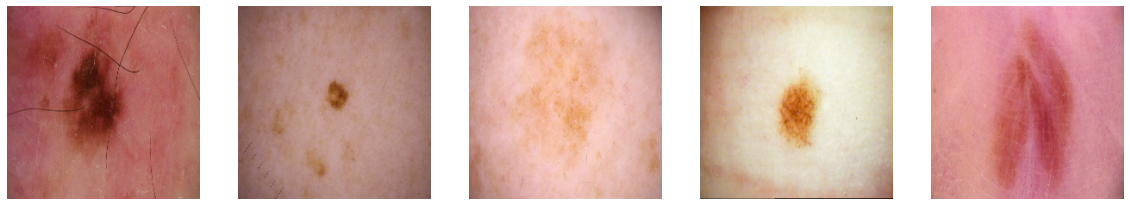

In [9]:
# Show the first five images of benign moles.
class_names = train_dataset.class_names

plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
  i = 0
  j = 0
  print("Examples of benign moles:\n")
  while i < 5:
    if(class_names[labels[j]] == "Benign"): 
      ax = plt.subplot(1, 5, i + 1)
      plt.imshow(images[j].numpy().astype("uint8"))
      plt.axis("off")
      i += 1
    j += 1

In [10]:
train_ds = train_dataset.unbatch()
images = list(train_ds.map(lambda x, y: x))
labels = list(train_ds.map(lambda x, y: y))

Examples of malignant melanomas:



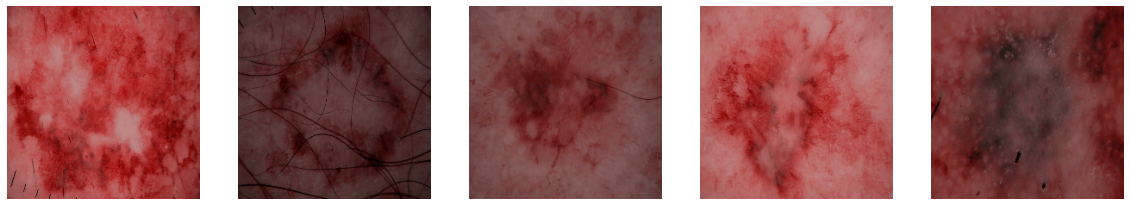

In [11]:
train_ds = train_dataset.unbatch()
images = list(train_ds.map(lambda x, y: x))
labels = list(train_ds.map(lambda x, y: y))

# And the first five images of malignant melanomas.
plt.figure(figsize=(20, 20))
i = 0
j = 0
index = labels.index(1)
print("Examples of malignant melanomas:\n")
while i < 5:
  if(class_names[labels[index + i]] == "Malignant"): 
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[index + i].numpy().astype("uint8"))
    plt.axis("off")
  i += 1

In [28]:
# Creation of the general model.
# Resize the images to have a new third dimension for the Convoutional Neuronal
# Network (CNN). The image shape then is (224, 224, 3)
IMG_SHAPE = IMG_SIZE + (3,)

# Create a first model based on the ResNet50 architecture with no precalculated
# weights
model_ResNet50 = tf.keras.applications.ResNet50(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               pooling = 'avg',
                                               weights = None)

# Visualize the model created
print(model_ResNet50.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
# Preparation of the data for the model.
preprocess_input = tf.keras.applications.resnet.preprocess_input
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_ResNet50(image_batch)
model_ResNet50.trainable = True

# The last layer only have one neuron as only two possible values are needed.
# Depending on the value obtained, the prediction is:
# If the value is a negative number, then the result is Benign .
# If the value is a positive number, then the result is Malignant. 
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(16, 1)


In [31]:
# 
inputs = tf.keras.Input(shape = (224, 224, 3))
x = preprocess_input(inputs)
x = model_ResNet50(x, training = False)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049

In [ ]:
# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

# Usamos la técnica de Early Stopping para evitar el sobreentrenamiento
callbacks = EarlyStopping(monitor = 'val_accuracy', patience = 20)

# Train the model
history = model.fit(train_dataset,
                    epochs = 100,
                    validation_data = val_dataset,
                    callbacks = callbacks)

Epoch 1/100
175/175 [==============================] - 103s 551ms/step - loss: 0.4862 - accuracy: 0.9646 - val_loss: 20.6942 - val_accuracy: 0.5000
Epoch 2/100
175/175 [==============================] - 94s 536ms/step - loss: 1.7055 - accuracy: 0.8789 - val_loss: 5.4286 - val_accuracy: 0.5000
Epoch 3/100
175/175 [==============================] - 94s 536ms/step - loss: 0.6082 - accuracy: 0.8607 - val_loss: 4.8557 - val_accuracy: 0.5000
Epoch 4/100
175/175 [==============================] - 94s 535ms/step - loss: 0.7364 - accuracy: 0.8082 - val_loss: 3.1426 - val_accuracy: 0.5000
Epoch 5/100
175/175 [==============================] - 95s 542ms/step - loss: 0.6625 - accuracy: 0.7811 - val_loss: 2.8829 - val_accuracy: 0.5000
Epoch 6/100
175/175 [==============================] - 93s 533ms/step - loss: 0.6862 - accuracy: 0.7229 - val_loss: 2.1013 - val_accuracy: 0.5000
Epoch 7/100
175/175 [==============================] - 94s 535ms/step - loss: 0.6576 - accuracy: 0.6950 - val_loss: 1.6211

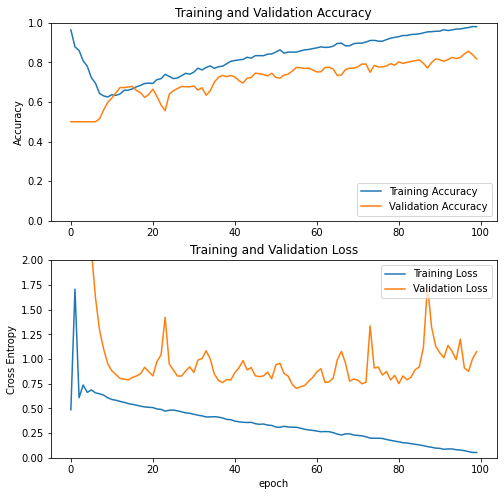

In [41]:
# Plot the results for the train and validation dataset:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc ='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc ='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
# Save the model
model.save('general_model.h5')

In [42]:
# Evaluate the model using the Test dataset.
loss_test, acc_test = model.evaluate(test_dataset, batch_size=BATCH_SIZE, 
                                     verbose=1)
print("Accuracy of the model for Test dataset: {:5.2f}%".format(100 * acc_test))
print("Loss of the model for Test dataset: {:5.2f}%".format(100 * loss_test))

13/13 [==============================] - 3s 194ms/step - loss: 1.8832 - accuracy: 0.6850
Accuracy of the model for Test dataset: 68.50%
Loss of the model for Test dataset: 188.32%


In [43]:
# Obtain the predictions of the Test.
predictions = model.predict(test_dataset, batch_size=BATCH_SIZE, 
                                     verbose=1) 
predictions_class = []
predictions_binary = []
for i in predictions:
  if i < 0:
    predictions_binary.append(0)
    predictions_class.append("Benign")
  else:
    predictions_binary.append(1)
    predictions_class.append("Malignant")

13/13 [==============================] - 3s 196ms/step


Examples of predictions of the Test dataset:



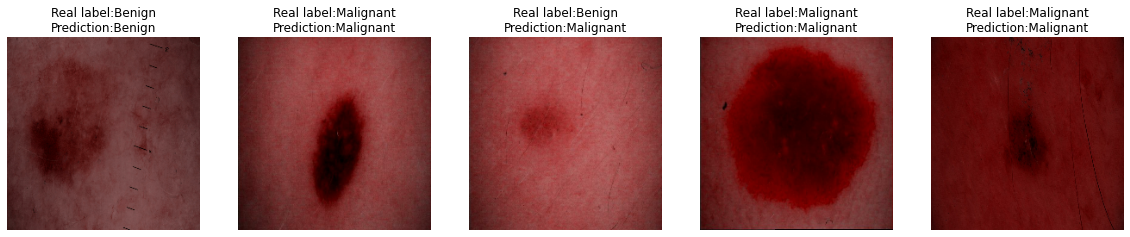

In [44]:
class_test = test_dataset.class_names

test_ds = test_dataset.unbatch()
images = list(test_ds.map(lambda x, y: x))
labels = list(test_ds.map(lambda x, y: y))

# Display some images of moles from the Test dataset, their diagnosis and the 
# prediction obtained.
plt.figure(figsize=(20, 20))

i = 0
print("Examples of predictions of the Test dataset:\n")
while i < 5:
  # Get five random numbers to select images in the test dataset
  rand_number = random.randrange(0, len(labels), 1)
  ax = plt.subplot(1, 5, i + 1)
  real_value = 'Real label:' + class_test[labels[rand_number]] + '\n'
  prediction_value = 'Prediction:' + predictions_class[rand_number]
  title = real_value + prediction_value
  plt.title(title)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.axis("off")
  i += 1

In [45]:
print('Confussion matrix for phototypes IV, V and VI:')
conf_matrix1 = metrics.confusion_matrix(labels, predictions_binary)
print(conf_matrix1)
print(' ')
print('True positives:', round(conf_matrix1[1,1]))
print('True negatives:', round(conf_matrix1[0,0]))
print('False positives:', round(conf_matrix1[1,0]))
print('False negatives:', round(conf_matrix1[0,1]))
print(' ')

# Display some statistics
print('Sensibility:', round(conf_matrix1[1,1]/(conf_matrix1[1,1]+conf_matrix1[1,0]),2))
print('Specificity:', round(conf_matrix1[0,0]/(conf_matrix1[0,0]+conf_matrix1[0,1]),2))
print('Positive predictive value (precision):', round(conf_matrix1[1,1]/(conf_matrix1[1,1]+conf_matrix1[0,1]),2))
print('Negative predictive value:', round(conf_matrix1[0,0]/(conf_matrix1[0,0]+conf_matrix1[1,0]),2))
print('Accuracy:', round((conf_matrix1[0,0]+conf_matrix1[1,1])/(conf_matrix1[0,0]+conf_matrix1[1,1]+
                                                         conf_matrix1[1,0]+conf_matrix1[0,1]),2))

Confussion matrix for phototypes IV, V and VI:
[[42 58]
 [ 7 93]]
 
True positives: 93
True negatives: 42
False positives: 7
False negatives: 58
 
Sensibility: 0.93
Specificity: 0.42
Positive predictive value (precision): 0.62
Negative predictive value: 0.86
Accuracy: 0.68
